In [89]:
#importing library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,classification_report
import tensorflow as tf

In [90]:
#loading the dataset
df=pd.read_csv('/kaggle/input/paysim1/PS_20174392719_1491204439457_log.csv',nrows=100000)
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
99995,10,PAYMENT,4020.66,C1410794718,159929.0,155908.34,M1257036576,0.00,0.00,0,0
99996,10,PAYMENT,18345.49,C744303677,6206.0,0.00,M1785344556,0.00,0.00,0,0
99997,10,CASH_IN,183774.91,C104331851,39173.0,222947.91,C36392889,54925.05,0.00,0,0
99998,10,CASH_OUT,82237.17,C707662966,6031.0,0.00,C1553004158,592635.66,799140.46,0,0


In [91]:
#getting the preliminary information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            100000 non-null  int64  
 1   type            100000 non-null  object 
 2   amount          100000 non-null  float64
 3   nameOrig        100000 non-null  object 
 4   oldbalanceOrg   100000 non-null  float64
 5   newbalanceOrig  100000 non-null  float64
 6   nameDest        100000 non-null  object 
 7   oldbalanceDest  100000 non-null  float64
 8   newbalanceDest  100000 non-null  float64
 9   isFraud         100000 non-null  int64  
 10  isFlaggedFraud  100000 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 8.4+ MB


In [92]:
#checking for missing value
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [93]:
{column:len(df[column].unique()) for column in df.columns}

{'step': 10,
 'type': 5,
 'amount': 99470,
 'nameOrig': 100000,
 'oldbalanceOrg': 58013,
 'newbalanceOrig': 48118,
 'nameDest': 51551,
 'oldbalanceDest': 53663,
 'newbalanceDest': 19158,
 'isFraud': 2,
 'isFlaggedFraud': 1}

In [94]:
def onehot_encode(df,column,prefix):
    df=df.copy()
    dummies=pd.get_dummies(df[column],prefix=prefix)
    df=pd.concat([df,dummies],axis=1)
    df=df.drop(column,axis=1)
    for column in df.columns:
        if df[column].dtypes=='bool':
            df[column]=df[column].astype(int)
    return df

In [95]:
# creating a function for preprocessing

def preprocess_inputs(df):
    df=df.copy()
    #dropping the type and isFlaggedFraud column
    df=df.drop(['step','nameOrig','isFlaggedFraud'],axis=1)

    #splitting
    df=onehot_encode(df,'type','tp')

    y=df['isFraud']
    x=df.drop('isFraud',axis=1)

  
    #train_test_split
    x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.7,random_state=123,shuffle=True)

    
    #creating a tokenizer and fit in the customer data

    tokenizer=tf.keras.preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts(x_train['nameDest'])
    print('Total number of customers:',len(tokenizer.word_index))
    

    #creating tokenizer list


    customer_train=tokenizer.texts_to_sequences(x_train['nameDest'])

    customer_test=tokenizer.texts_to_sequences(x_test['nameDest'])
    
    customer_train=tf.keras.preprocessing.sequence.pad_sequences(customer_train,maxlen=1)
    customer_test=tf.keras.preprocessing.sequence.pad_sequences(customer_test,maxlen=1)

    #dropping nameDest column

    x_train=x_train.drop('nameDest',axis=1)
    x_test=x_test.drop('nameDest',axis=1)

    scaler=StandardScaler()

    scaler.fit(x_train)
    x_train=pd.DataFrame(scaler.transform(x_train),columns=x_train.columns,index=x_train.index)
    x_test=pd.DataFrame(scaler.transform(x_test),columns=x_test.columns,index=x_test.index)


    
    return x_train,x_test,y_train,y_test,customer_train,customer_test

In [96]:
x_train,x_test,y_train,y_test,customer_train,customer_test=preprocess_inputs(df)
x_train

Total number of customers: 38568


,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,tp_CASH_IN,tp_CASH_OUT,tp_DEBIT,tp_PAYMENT,tp_TRANSFER
52308,-0.428224,-0.297820,-0.309779,-0.349280,-0.398371,-0.502588,1.503551,-0.098822,-0.808767,-0.307802
27380,0.097078,-0.307315,-0.330644,-0.366235,-0.349066,-0.502588,1.503551,-0.098822,-0.808767,-0.307802
94588,-0.444816,-0.317563,-0.327146,-0.366235,-0.422655,-0.502588,-0.665092,-0.098822,1.236451,-0.307802
7361,-0.502633,-0.303894,-0.306380,-0.366235,-0.422655,-0.502588,-0.665092,-0.098822,1.236451,-0.307802
52298,0.485377,-0.310448,-0.330644,0.298205,0.775764,-0.502588,1.503551,-0.098822,-0.808767,-0.307802
...,...,...,...,...,...,...,...,...,...,...
63206,2.166265,-0.329239,-0.330644,0.737033,0.799345,-0.502588,-0.665092,-0.098822,-0.808767,3.248841
61404,-0.437985,-0.323945,-0.330644,-0.366235,-0.359279,-0.502588,1.503551,-0.098822,-0.808767,-0.307802
17730,-0.093506,-0.327705,-0.276808,-0.148123,-0.146220,1.989701,-0.665092,-0.098822,-0.808767,-0.307802
28030,-0.496777,-0.329239,-0.330644,-0.086363,-0.253525,-0.502588,1.503551,-0.098822,-0.808767,-0.307802


In [106]:
#Model
x_inputs=tf.keras.Input(shape=(10,))
customer_inputs=tf.keras.Input(shape=(1,))
#x

x_dense1=tf.keras.layers.Dense(64,activation='relu')(x_inputs)
x_dense2=tf.keras.layers.Dense(64,activation='relu')(x_dense1)


customer_embedding=tf.keras.layers.Embedding(input_dim=38569,
                                      output_dim=64,
                                      input_length=1
                                     )(customer_inputs)

customer_flatten=tf.keras.layers.Flatten()(customer_embedding)


concat=tf.keras.layers.concatenate([x_dense2,customer_flatten])


outputs=tf.keras.layers.Dense(1,activation='sigmoid')(concat)

model=tf.keras.Model(inputs=[x_inputs,customer_inputs],outputs=outputs)


model.summary()






Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_10      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │        704 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 1, 64)     │  2,468,416 │ input_layer_10[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 64)        │      4,160 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 64)        │          0 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128)       │          0 │ dense_9[0][0],    │
│ (Concatenate)       │                   │            │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 1)         │        129 │ concatenate_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,473,409 (9.44 MB)

 Trainable params: 2,473,409 (9.44 MB)

 Non-trainable params: 0 (0.00 B)

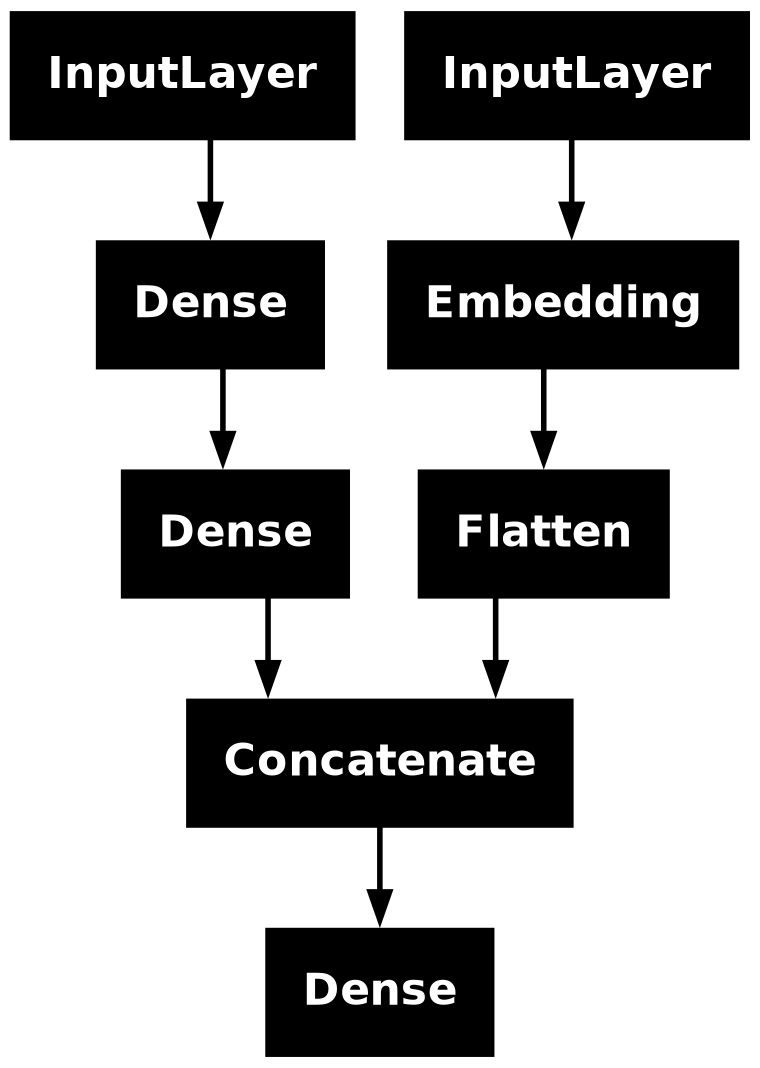

In [107]:
tf.keras.utils.plot_model(model)

In [110]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy',tf.keras.metrics.AUC(name='auc')])



In [113]:
history=model.fit([x_train,customer_train],y_train,validation_split=0.2,batch_size=32,epochs=10,
                 callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2,restore_best_weights=True)])

Epoch 1/10


I0000 00:00:1733739014.258296    3079 service.cc:145] XLA service 0x7ba78800a3a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733739014.258353    3079 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  90/1750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9750 - auc: 0.7538 - loss: 0.3146

I0000 00:00:1733739015.340250    3079 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1750/1750 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9968 - auc: 0.5501 - loss: 0.0472 - val_accuracy: 0.9986 - val_auc: 0.7859 - val_loss: 0.0088
Epoch 2/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9989 - auc: 0.7584 - loss: 0.0067 - val_accuracy: 0.9986 - val_auc: 0.7200 - val_loss: 0.0089
Epoch 3/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9986 - auc: 0.9919 - loss: 0.0042 - val_accuracy: 0.9983 - val_auc: 0.7282 - val_loss: 0.0104


In [114]:
model.evaluate([x_test,customer_test],y_test)

938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9993 - auc: 0.7443 - loss: 0.0059


[0.008232236839830875, 0.9990000128746033, 0.7740312814712524]

In [115]:
y_pred=model.predict([x_test,customer_test])
print(y_pred)

938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
[[1.0458735e-04]
 [1.0049814e-04]
 [1.0118145e-04]
 ...
 [2.7850776e-03]
 [3.3156923e-03]
 [9.9544370e-05]]


In [118]:
y_pred=(np.squeeze(y_pred)>0.5).astype(int)

In [119]:
sum(y_pred)

0

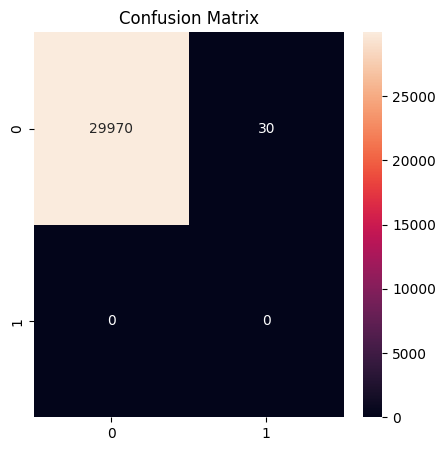

In [126]:
cm=confusion_matrix(y_pred,y_test)
plt.figure(figsize=(5,5))
plt.title('Confusion Matrix')
sns.heatmap(cm,annot=True,fmt='g')
plt.show()

In [123]:
sum(y_test)

30

In [124]:
clr=classification_report(y_pred,y_test)
print(clr)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     30000
           1       0.00      0.00      0.00         0

    accuracy                           1.00     30000
   macro avg       0.50      0.50      0.50     30000
weighted avg       1.00      1.00      1.00     30000



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [108]:
df['isFraud'].value_counts()

isFraud
0    99884
1      116
Name: count, dtype: int64

In [101]:
customer_embedding.shape

(None, 1, 64)

In [104]:
customer_flatten.shape

(None, 64)

In [ ]:
customer_test

In [ ]:
x['type'].unique()